In [1]:
# 1. Clone the DiffCut repository and cd into it
!git clone https://github.com/PaulCouairon/DiffCut.git
%cd DiffCut

fatal: destination path 'DiffCut' already exists and is not an empty directory.
/content/DiffCut


In [2]:
# 2. Install dependencies
!pip install -r requirements.txt
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-t226ijsw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-t226ijsw
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done


In [3]:
# 3. Imports & path setup
import sys
sys.path.append('/content/DiffCut')

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image, ImageFilter, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from google.colab import files

from tools.ldm import LdmExtractor
from diffcut.recursive_normalized_cut import DiffCut
from tools.pamr import PAMR
from scipy.ndimage import median_filter


In [4]:
# 4. Mask refinement helper
def mask_refinement(raw_labels, image_tensor):
    masks = torch.cat([1. * (raw_labels == lbl) for lbl in torch.unique(raw_labels)], dim=1)
    refined = PAMR(num_iter=30, dilations=[1,2,4,8,12,24,32,64])(image_tensor, masks)
    refined = 1. * torch.argmax(refined, dim=1)
    refined = median_filter(refined.cpu().numpy(), 3).astype(int)
    return refined

In [5]:
# 5. Upload custom image
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

Saving Capstone.jpg to Capstone.jpg


In [8]:
# 6. Load image
pil_img = Image.open(img_path).convert('RGB')
img_tensor = T.ToTensor()(pil_img).unsqueeze(0)
_, _, orig_h, orig_w = img_tensor.shape

In [ ]:
# 7. Extract features
extractor = LdmExtractor(model_name="SSD-1B")
# Convert the image tensor to half precision (fp16)
img_tensor = img_tensor.type(torch.float16)
features = extractor(img_tensor, step=50, img_size=512)

Loading SD model


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

SD model loaded


/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
# 8. Generate segmentation masks
masks_raw = DiffCut().generate_masks(
    features,
    tau=0.5,
    mask_size=(orig_h, orig_w),
    alpha=10,
    img_size=512
)
masks_raw = torch.Tensor(masks_raw).to("cuda")

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.41 GiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 GiB is free. Process 106376 has 4.62 GiB memory in use. Of the allocated memory 4.25 GiB is allocated by PyTorch, and 210.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
# 9. Refine masks
img_resized = F.interpolate(img_tensor, size=(512,512), mode='bilinear')
mask_refined = mask_refinement(masks_raw, img_resized)[0]

In [10]:
# 10. Create blurred background composite
background_blur = pil_img.resize((512,512)).filter(ImageFilter.GaussianBlur(radius=15))
mask_img = Image.fromarray((mask_refined * 255).astype(np.uint8))
composited = Image.composite(pil_img.resize((512,512)), background_blur, mask_img)

In [11]:
# 11. Overlay annotation
draw = ImageDraw.Draw(composited)
font = ImageFont.load_default()
text = "Landmark"  # Change annotation as needed
ys, xs = np.where(mask_refined)
if ys.size and xs.size:
    draw.text((xs.min(), ys.min()-20), text, fill='white', font=font)

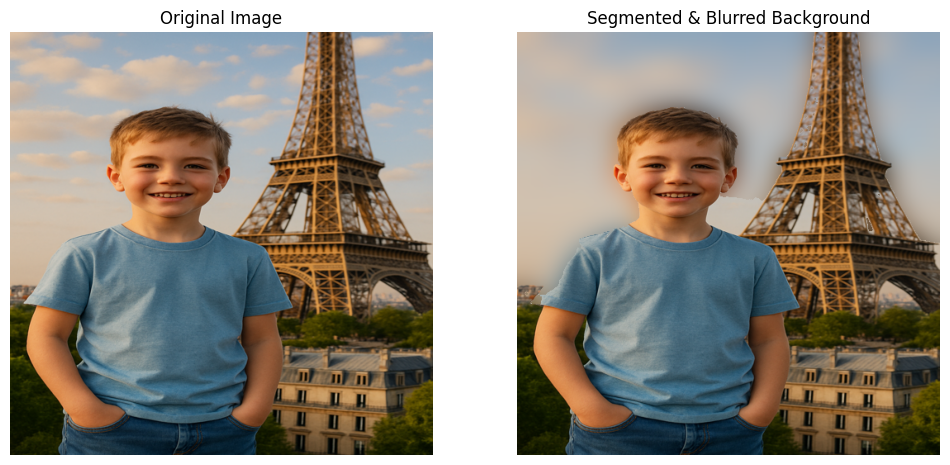

In [12]:
# 12. Display results
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(pil_img.resize((512,512)))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(composited)
axes[1].set_title("Segmented & Blurred Background")
axes[1].axis("off")

plt.show()

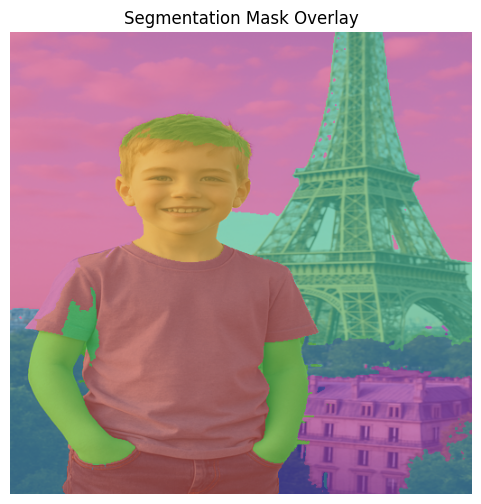

In [13]:
# 9. Create colored overlay
colors = sns.hls_palette(len(np.unique(mask_refined)), h=0.9)
cmap = ListedColormap(colors)
overlay = np.array(pil_img.resize((512,512)))
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.imshow(mask_refined, cmap=cmap, alpha=0.6)
plt.axis('off')
plt.title("Segmentation Mask Overlay")
plt.show()